In [2]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit
import numpy as np
import qiskit
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
print(qiskit.__version__)

2.1.1


Idea is to:
1. Prepare two qubits in ++
2. Simulate a stark shift
2. Do N XX gates
4. Do analysis pulses and look at stark shifts

In [35]:
def sim_stark_shift(n_xx_gates, common_mode_shift, diff_mode_shift):
    # Parameters
    n_steps = 100  
    rz_angles = np.linspace(0, 2*np.pi, n_steps) 

    comm = common_mode_shift
    diff = diff_mode_shift
    stark_shift_q0 = (comm - diff) * 2 * np.pi
    stark_shift_q1 = (comm + diff) * 2 * np.pi

    # Initialize arrays for populations
    qubit0_probs = np.zeros(n_steps)
    qubit1_probs = np.zeros(n_steps)

    for i, angle in enumerate(rz_angles):
        qc = QuantumCircuit(2)
        
        # Prepare State
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        qc.rz(np.pi/2, 0)
        qc.rz(np.pi/2, 1)

        for n in range(n_xx_gates):
            # Apply XX gate
            if n % 2 == 0:
                qc.rxx(np.pi / 2, 0, 1)
            else:
                qc.rxx(-np.pi / 2, 0, 1)
            
            # Apply stark shift
            qc.rz(stark_shift_q0, 0)
            qc.rz(stark_shift_q1, 1)

        # Analysis pulses
        qc.rz(angle, 0)
        qc.rz(angle, 1)
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        
        state = Statevector(qc)
        
        # Draw the circuit one time
        if angle == 0:
            print(qc.draw())

        # Calculate populations
        qubit0_probs[i] = state.probabilities([0])[1]
        qubit1_probs[i] = state.probabilities([1])[1]

    qubit_0_min = rz_angles[np.argmin(qubit0_probs)]
    qubit_1_min = rz_angles[np.argmin(qubit1_probs)]
    print(f"minimum of qubit 0 at:{round(qubit_0_min, 6)} rad")
    print(f"minimum of qubit 1 at:{round(qubit_1_min, 6)} rad")
    print(f"difference: {qubit_0_min - qubit_1_min}")
    plt.figure(figsize=(10, 5))
    plt.plot(rz_angles, qubit0_probs, label="Qubit 0 |1⟩ Population", color="blue")
    plt.plot(rz_angles, qubit1_probs, label="Qubit 1 |1⟩ Population", color="red", linestyle="--")
    plt.xlabel("Rz Angle (radians)")
    plt.title(f"Stark shift with {n_xx_gates} XX gate - {comm}% common mode shift {diff}% differential shift")
    plt.ylabel("Population")
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
            ['0', 'π/2', 'π', '3π/2', '2π'])
    plt.legend()
    plt.grid(True)
    plt.show()
    return qubit_0_min, qubit_1_min

---Trying 0 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     ├─────────┤├─────────┤├───────┤├─────────┤
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.586663 rad
minimum of qubit 1 at:1.586663 rad
difference: 0.0


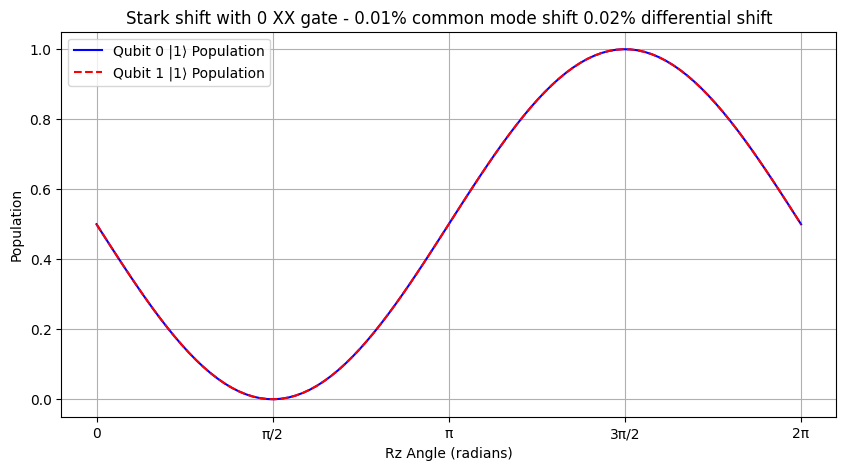

--------------
---Trying 1 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐├───────┤├─────────┤
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘└───────────┘└────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.650129 rad
minimum of qubit 1 at:1.396263 rad
difference: 0.2538660730173572


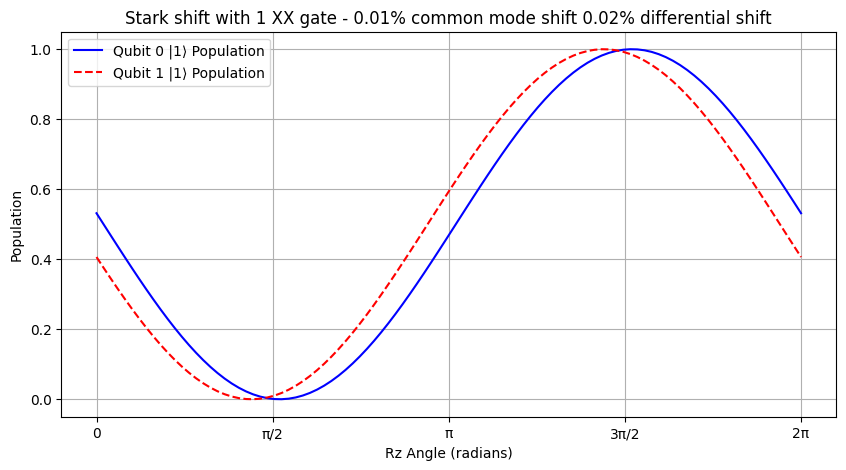

--------------
---Trying 2 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────┐┌─────────┐
«q_0: ┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
«     ├───────────┴┐├───────┤├─────────┤
«q_1: ┤ Rz(0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.650129 rad
minimum of qubit 1 at:1.396263 rad
difference: 0.2538660730173572


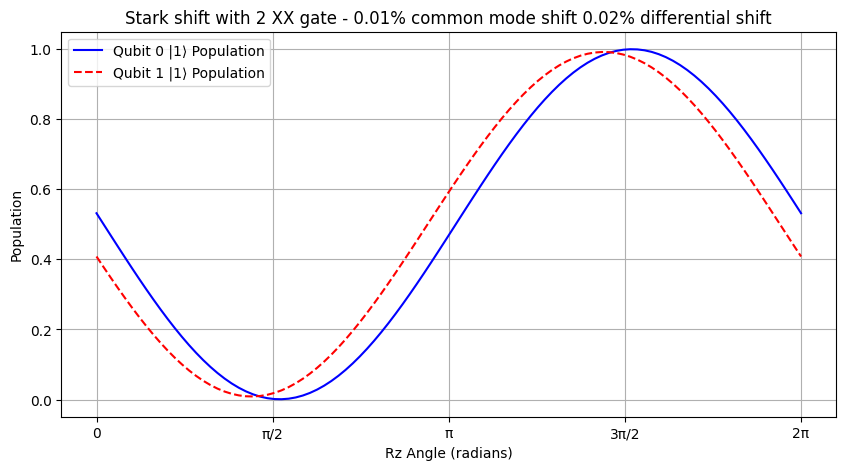

--------------
---Trying 3 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌───────┐┌─────────┐
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐├───────┤├─────────┤
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └────────────┘└───────────┘└────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.713596 rad
minimum of qubit 1 at:1.205864 rad
difference: 0.5077321460347142


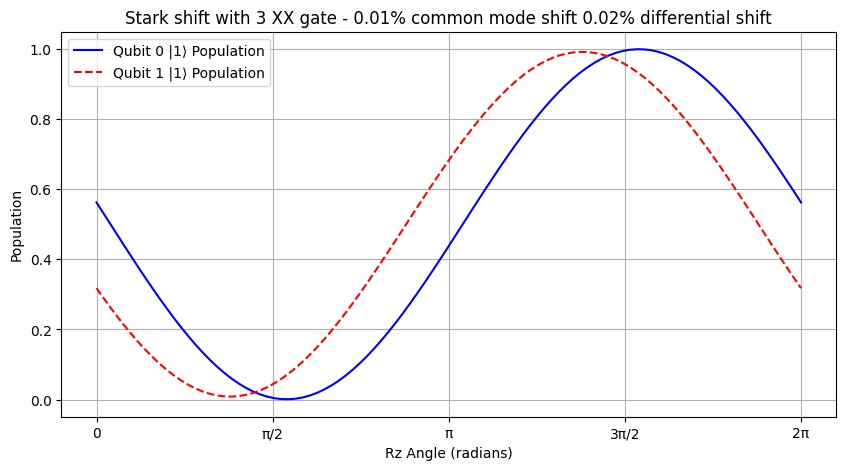

--------------
---Trying 4 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────┐┌─────────┐
«q_0: ┤ Rz(0) ├┤ Rx(π/2) ├
«     ├───────┤├─────────┤
«q_1: ┤ Rz(0) ├┤ Rx(π/2) ├
«     └───────┘└─────────┘
minimum of qubit 0 at:1.713596 rad
minimum of qubit 1 at:1.2058

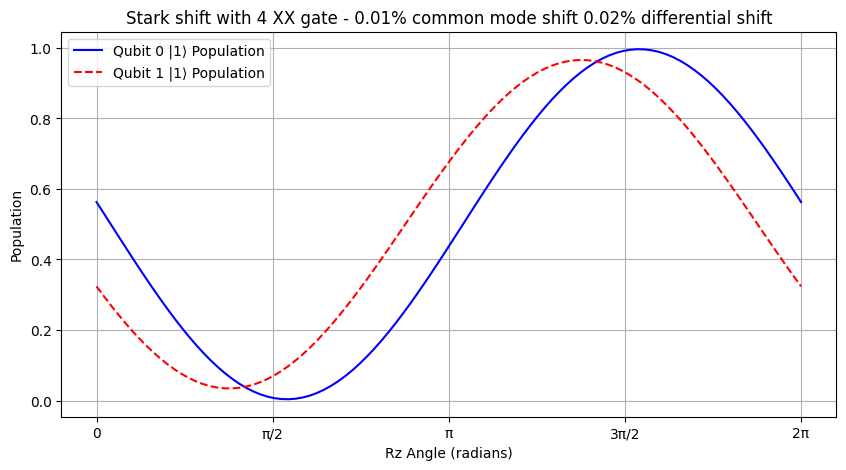

--------------
---Trying 5 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌───────┐┌─────────┐
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
«     │  Rxx(π/2) │├───────────┴┐├───────┤├─────────┤
«q_1: ┤1          ├┤ Rz(0.1885) ├┤ R

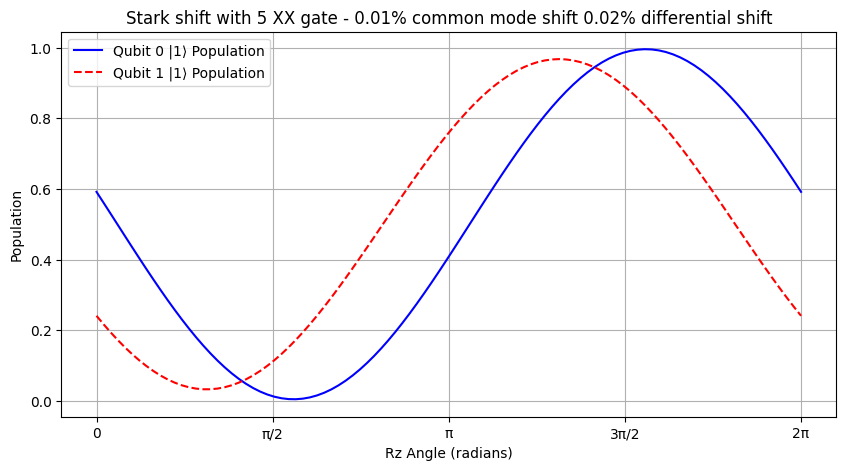

--------------
---Trying 6 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ ┌───────┐»
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─┤ Rz(0) ├»
«     │  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├──────

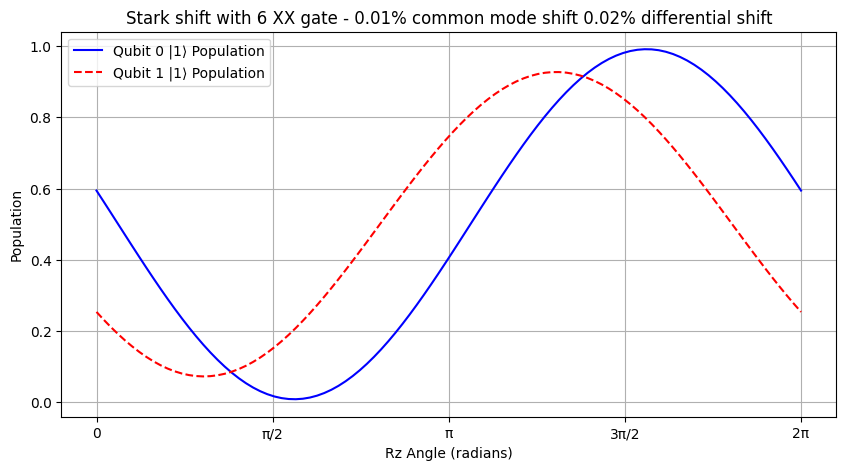

--------------
---Trying 7 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ ┌───────────┐»
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─┤0          ├»
«     │  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) 

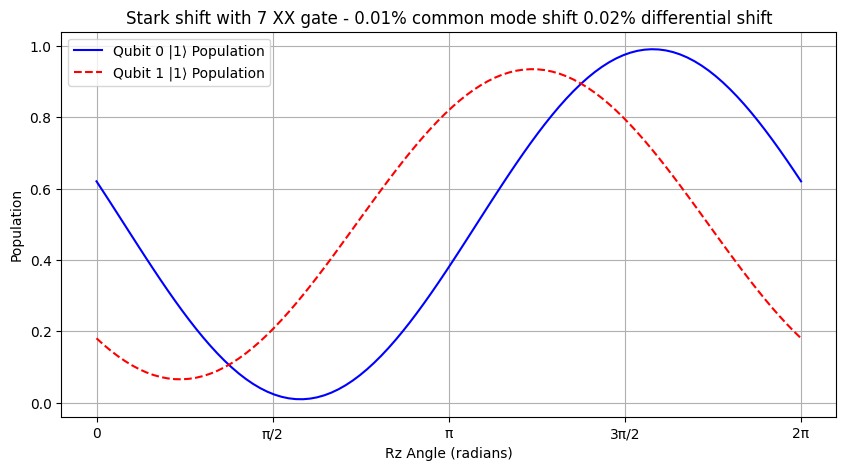

--------------
---Trying 8 XX -XX Gates, state prepared in + + ---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     ├─────────┤├─────────┤│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤1          ├┤ Rz(0.1885) ├┤1           ├»
     └─────────┘└─────────┘└───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ ┌───────────┐»
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─┤0          ├»
«     │  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) 

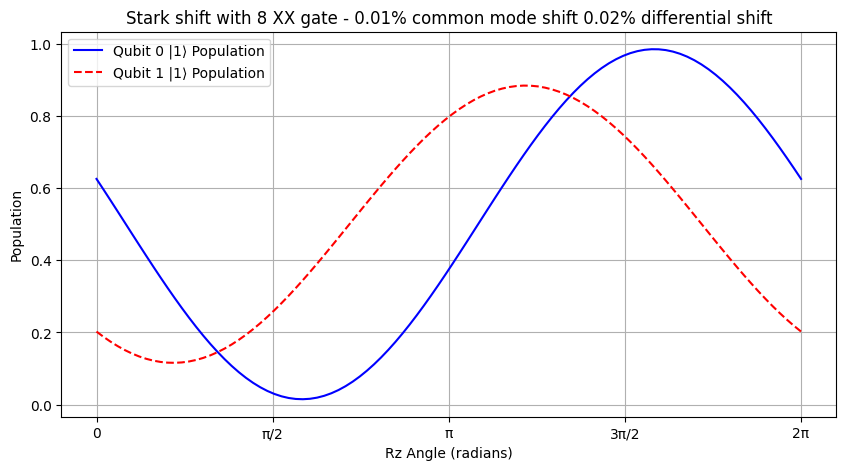

--------------


In [36]:
comm = 0.01
diff = 0.02
qubit_0_mins = list()
qubit_1_mins = list()
num_xxs = np.array(range(9))
for i in range(9):
    print(f"---Trying {i} XX -XX Gates, state prepared in + + ---")
    qubit_0_min, qubit_1_min = sim_stark_shift(i, comm, diff)
    print("--------------")
    qubit_0_mins.append(qubit_0_min)
    qubit_1_mins.append(qubit_1_min)

Text(0.5, 1.0, 'Stark shift from n XX -XX gates with state prepped in + +')

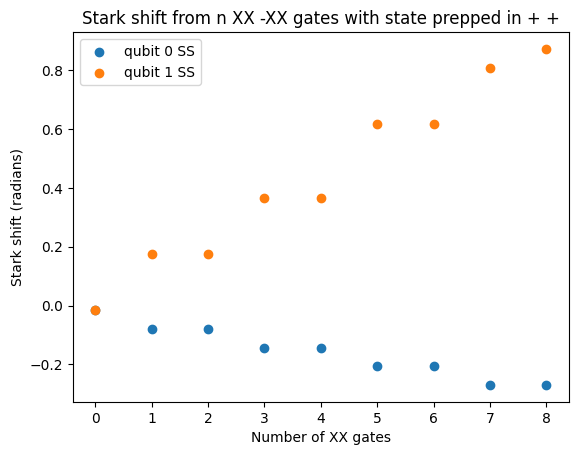

In [ ]:
qubit_0_ss = (np.pi * 0.5) - np.array(qubit_0_mins)
qubit_1_ss = (np.pi * 0.5) - np.array(qubit_1_mins)
plt.scatter(num_xxs, qubit_0_ss, label="qubit 0 SS")
plt.scatter(num_xxs, qubit_1_ss, label="qubit 1 SS")
plt.legend()
plt.xlabel("Number of XX gates")
plt.ylabel("Stark shift (radians)")
plt.title("Stark shift from n gates (alternating XX -XX) with state prepped in + +")


Same as above, but instead prepare the state in + 0

In [15]:
def sim_stark_shift_plus0(n_xx_gates, common_mode_shift, diff_mode_shift):
    # Parameters
    n_steps = 100  
    rz_angles = np.linspace(0, 2*np.pi, n_steps) 

    comm = common_mode_shift
    diff = diff_mode_shift
    stark_shift_q0 = (comm - diff) * 2 * np.pi
    stark_shift_q1 = (comm + diff) * 2 * np.pi

    # Initialize arrays for populations
    qubit0_probs = np.zeros(n_steps)
    qubit1_probs = np.zeros(n_steps)

    for i, angle in enumerate(rz_angles):
        qc = QuantumCircuit(2)
        
        # Prepare State
        qc.rx(np.pi/2, 0)
        # qc.rx(np.pi/2, 1)
        qc.rz(np.pi/2, 0)
        # qc.rz(np.pi/2, 1)

        for n in range(n_xx_gates):
            # Apply XX gate
            if n % 2 == 0:
                qc.rxx(np.pi / 2, 0, 1)
            else:
                qc.rxx(-np.pi / 2, 0, 1)
            
            # Apply stark shift
            qc.rz(stark_shift_q0, 0)
            qc.rz(stark_shift_q1, 1)

        # Analysis pulses
        qc.rz(angle, 0)
        qc.rz(angle, 1)
        qc.rx(np.pi/2, 0)
        qc.rx(np.pi/2, 1)
        
        state = Statevector(qc)
        
        # Draw the circuit one time
        if angle == 0:
            print(qc.draw())

        # Calculate populations
        qubit0_probs[i] = state.probabilities([0])[1]
        qubit1_probs[i] = state.probabilities([1])[1]

    qubit_0_min = rz_angles[np.argmin(qubit0_probs)]
    qubit_1_min = rz_angles[np.argmin(qubit1_probs)]
    print(f"minimum of qubit 0 at:{round(qubit_0_min, 6)} rad")
    print(f"minimum of qubit 1 at:{round(qubit_1_min, 6)} rad")
    print(f"difference: {qubit_0_min - qubit_1_min}")
    plt.figure(figsize=(10, 5))
    plt.plot(rz_angles, qubit0_probs, label="Qubit 0 |1⟩ Population", color="blue")
    plt.plot(rz_angles, qubit1_probs, label="Qubit 1 |1⟩ Population", color="red", linestyle="--")
    plt.xlabel("Rz Angle (radians)")
    plt.title(f"Stark shift with {n_xx_gates} XX gate - {comm}% common mode shift {diff}% differential shift")
    plt.ylabel("Population")
    plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],
            ['0', 'π/2', 'π', '3π/2', '2π'])
    plt.legend()
    plt.grid(True)
    plt.show()
    return qubit_0_min, qubit_1_min

---Trying 0 XX -XX Gates, state prepared in + 0---
     ┌─────────┐┌─────────┐┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤ Rz(0) ├┤ Rx(π/2) ├
     └┬───────┬┘├─────────┤└───────┘└─────────┘
q_1: ─┤ Rz(0) ├─┤ Rx(π/2) ├────────────────────
      └───────┘ └─────────┘                    
minimum of qubit 0 at:1.586663 rad
minimum of qubit 1 at:1.713596 rad
difference: -0.1269330365086785


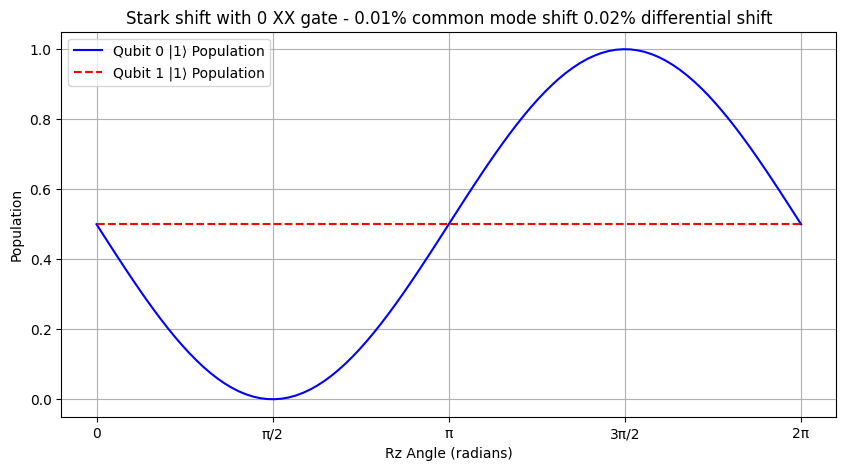

--------------
---Trying 1 XX -XX Gates, state prepared in + 0---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌───────┐┌─────────┐
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
     └─────────┘└─────────┘│  Rxx(π/2) │├───────────┴┐├───────┤├─────────┤
q_1: ──────────────────────┤1          ├┤ Rz(0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
                           └───────────┘└────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.650129 rad
minimum of qubit 1 at:2.982926 rad
difference: -1.3327968833411243


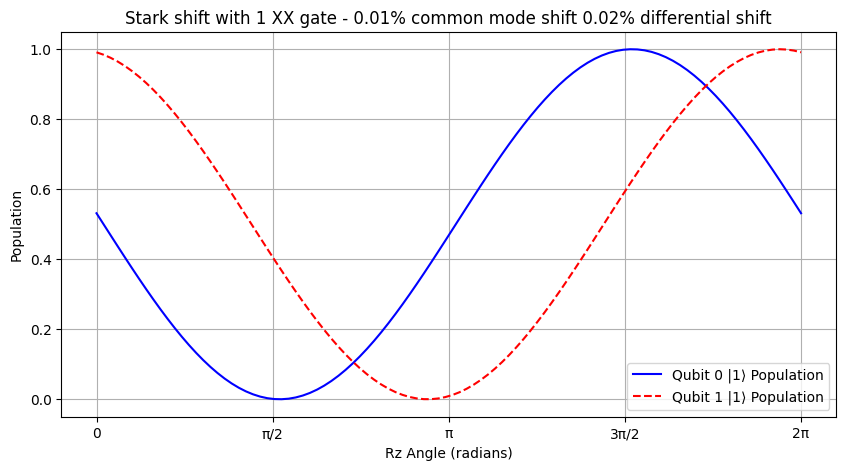

--------------
---Trying 3 XX -XX Gates, state prepared in + 0---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     └─────────┘└─────────┘│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ──────────────────────┤1          ├┤ Rz(0.1885) ├┤1           ├»
                           └───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌───────┐┌─────────┐
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐├───────┤├─────────┤
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤ Rz(0) ├┤ Rx(π/2) ├
«     └────────────┘└───────────┘└────────────┘└───────┘└─────────┘
minimum of qubit 0 at:1.713596 rad
minimum of qubit 1 at:2.792527 rad
difference: -1.0789308103237671


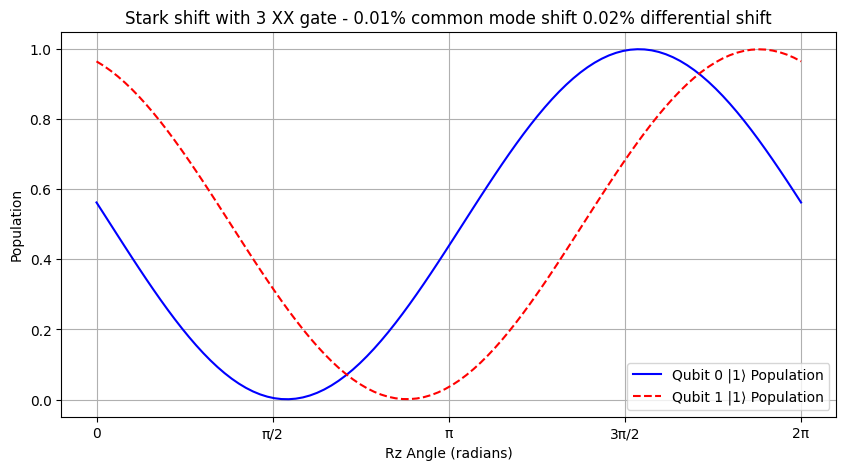

--------------
---Trying 5 XX -XX Gates, state prepared in + 0---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     └─────────┘└─────────┘│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ──────────────────────┤1          ├┤ Rz(0.1885) ├┤1           ├»
                           └───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌───────┐┌─────────┐
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤ Rz(0) ├┤ Rx(π/2) ├
«     │  Rxx(π/2) │├───────────┴┐├───────┤├─────────┤
«q_1: ┤1          ├┤ Rz(0.1885) ├┤ Rz

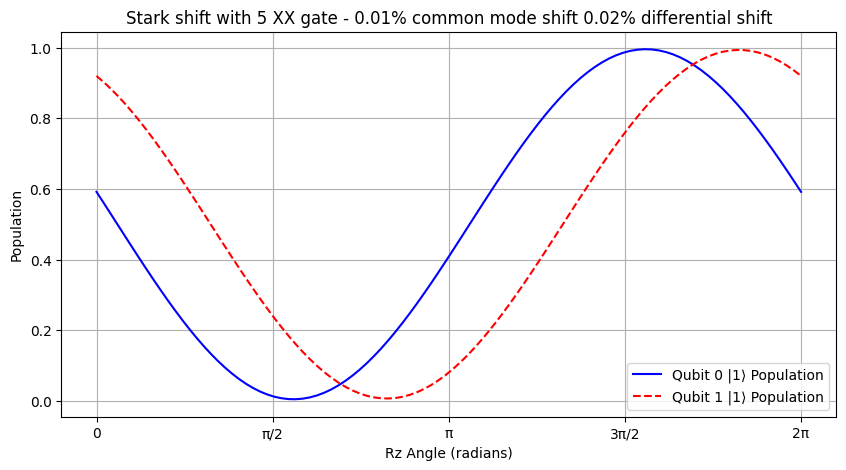

--------------
---Trying 7 XX -XX Gates, state prepared in + 0---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     └─────────┘└─────────┘│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ──────────────────────┤1          ├┤ Rz(0.1885) ├┤1           ├»
                           └───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ ┌───────────┐»
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─┤0          ├»
«     │  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │

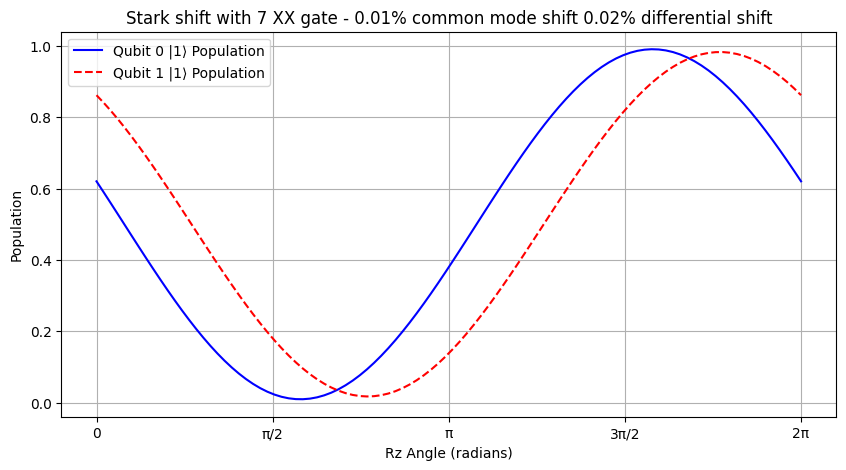

--------------
---Trying 9 XX -XX Gates, state prepared in + 0---
     ┌─────────┐┌─────────┐┌───────────┐┌───────────┐ ┌────────────┐»
q_0: ┤ Rx(π/2) ├┤ Rz(π/2) ├┤0          ├┤ Rz(-π/50) ├─┤0           ├»
     └─────────┘└─────────┘│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │»
q_1: ──────────────────────┤1          ├┤ Rz(0.1885) ├┤1           ├»
                           └───────────┘└────────────┘└────────────┘»
«     ┌───────────┐ ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ »
«q_0: ┤ Rz(-π/50) ├─┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─»
«     ├───────────┴┐│  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │├───────────┴┐»
«q_1: ┤ Rz(0.1885) ├┤1          ├┤ Rz(0.1885) ├┤1           ├┤ Rz(0.1885) ├»
«     └────────────┘└───────────┘└────────────┘└────────────┘└────────────┘»
«     ┌───────────┐┌───────────┐ ┌────────────┐┌───────────┐ ┌───────────┐»
«q_0: ┤0          ├┤ Rz(-π/50) ├─┤0           ├┤ Rz(-π/50) ├─┤0          ├»
«     │  Rxx(π/2) │├───────────┴┐│  Rxx(-π/2) │

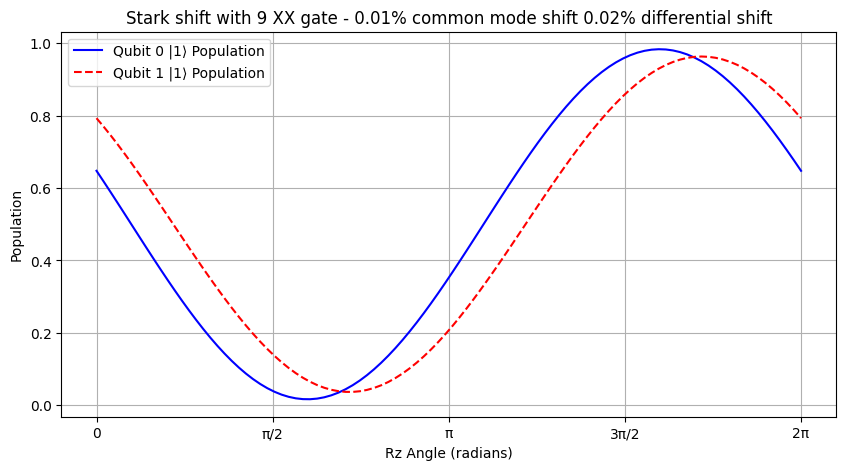

--------------


In [31]:
comm = 0.01
diff = 0.02
qubit_0_mins2 = list()
qubit_1_mins2 = list()
num_xxs2 = [i for i in range(11) if i == 0 or i % 2 == 1]
for i in num_xxs2:
    print(f"---Trying {i} XX -XX Gates, state prepared in + 0---")
    qubit_0_min, qubit_1_min = sim_stark_shift_plus0(i, comm, diff)
    print("--------------")
    qubit_0_mins2.append(qubit_0_min)
    qubit_1_mins2.append(qubit_1_min)
        

Text(0.5, 1.0, 'Stark shift from n XX -XX gates with state prepped in 0 +')

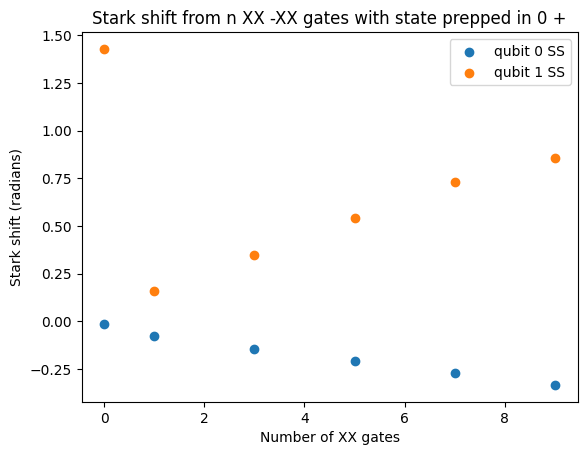

In [ ]:
qubit_0_ss = (np.pi * 0.5) - np.array(qubit_0_mins2)
qubit_1_ss = np.pi - np.array(qubit_1_mins2)
plt.scatter(num_xxs2, qubit_0_ss, label="qubit 0 SS")
plt.scatter(num_xxs2, qubit_1_ss, label="qubit 1 SS")
plt.legend()
plt.xlabel("Number of XX gates")
plt.ylabel("Stark shift (radians)")
plt.title("Stark shift from n gates (alternating XX -XX) with state prepped in 0 +")